# Multiclass Logistic Regression
## One vs. All

### What it is?
The previous tutorial on [Logistic Regression](3_BinaryLogisticRegression.ipynb) was about binary output, so the input could belong to class 0 or 1, but that's not very useful because plenty of times the range of classes is greater than two. Here is where this approach fits, it's a generalization of the Binary Logistic Regression so that it can be applied to any number of output classes.

Its name comes from the fact that in order to generalize the model, we create as many "mini-models" as classes and we train each one to identify only one class, so when it sees an input, it knows if it belongs to that class or not, but knows nothing about the other classes. ![From Binary to Multiclass Logistic Regression](https://houxianxu.github.io/images/logisticRegression/4.png)

More formally speaking, we have an input $x \in \mathbb{R}^n$ and a output $y \in \mathbb{R}^m$, with $m$ being the number of output classes. The output vector contains a 1 in the position where the class that it belongs to is associated. In the case of the MNIST dataset, a label could be: $y = \text{[0 0 0 1 0 0 0 0 0 0]}$ to indicate that it's the digit three. What we do is train $m$ "mini-models" that can say if an input, for example, is a 3 or not, but in the case that it's not a 3, it doesn't know which digit it is.

At the end, the predicted output is the one "mini-model" whose output probability is the greatest. ![Prediction Multiclass Logistic Regression](https://www.pugetsystems.com/pic_disp.php?id=43182)

###  General explanation of notebook
The structure of the notebook is getting all the data and a simple visualization. Later, we will use the scikit-learn library implementation of Logistic Regression. Finally, we will go through the mathematical explanation of this One vs. All generalization and implement it from scratch to compare it.

### 1. Getting the data
First of all, we have to import all of the dependencies that we will use to retrieve the data, clean it and also visualize it.

In [1]:
import numpy as np #library to work with vectors and matrix
import matplotlib.pyplot as plt #library to work with graphics and plots

%matplotlib inline

We're going to use the famous MNIST dataset, since it contains handritten digits (from 0 to 9) that will represent the 10 output classes.

In [2]:
def mnist(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST. Default is
            /home/USER/data/mnist or C:\Users\USER\data\mnist.
            Create if nonexistant. Download any missing files.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    #Taken from: 'https://mattpetersen.github.io/load-mnist-with-numpy'
    import gzip
    import os
    from urllib.request import urlretrieve

    url = 'http://yann.lecun.com/exdb/mnist/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']

    if path is None:
        # Set path to /home/USER/data/mnist or C:\Users\USER\data\mnist
        path = os.path.join(os.path.expanduser('~'), 'data', 'mnist')

    # Create path if it doesn't exist
    os.makedirs(path, exist_ok=True)

    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    test_images = _images(os.path.join(path, files[2]))
    test_labels = _labels(os.path.join(path, files[3]))

    return train_images, train_labels, test_images, test_labels

In [3]:
train_images, train_labels, test_images, test_labels = mnist("../datasets/MNIST")

This is an example of the structure of the outputs, a vector $y$ with a 1 matching the position of the sample in the training set that match that class and 0 otherwise.

In [4]:
test_labels[0]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=uint8)

The following function transforms the previous vector, also called one-hot vector, to the real digit.

In [5]:
def from_one_hot_to_vector(labels):
    return np.argmax(labels, axis=1)

After load the MNIST dataset, it's always a good idea to visualize the dataset and how it is composed. 
Each image is composed of 768 attributes, each one representing a pixel from a 28x28 image.

In [6]:
def plot_number_image(image, label):
        r"""Plots the handwritten image in a matplotlib figure

        Args:
            image: NumPy array with the values of an image from the MNIST dataset.
                    It should be 28x28 pixels each one.
                    
            label: Scalar with the label (a number, not a one hot vector) of the image
        """
        # Make those columns into a array of 8-bits pixels
        # This array will be of 1D with length 784
        # The pixel intensity values are float from 0 to 1
        # Reshape the array into 28 x 28 array (2-dimensional array)
        pixels = image.reshape((28, 28))

        # Plot
        plt.title('Label is {}'.format(label))
        plt.imshow(pixels, cmap='gray')
        plt.show()

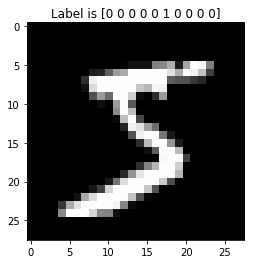

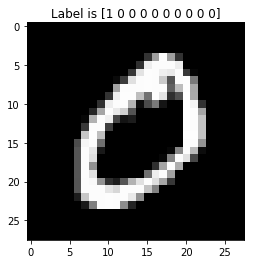

In [7]:
plot_number_image(train_images[0], train_labels[0])
plot_number_image(train_images[1], train_labels[1])

Above we see the image, which is represented by an input vector of 784 dimensions (28x28 pixels, each pixel a value) with range 0-1.

In [8]:
train_images[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

### 2. MultiClass Logistic Regresssion with Scikit-learn 
In order to get a general idea of the result of MultiClass Logistic Regression, learn how to use a powerful library and later compare it with our algorithm, we are going first to do it with the scikit-learn implementation.

It's very easy to use and with only 2 lines, we can have a functional model already.

In [9]:
%%time
from sklearn import linear_model
from sklearn.metrics import accuracy_score

logreg = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs')
logreg.fit(train_images, from_one_hot_to_vector(train_labels)) 

Y_pred = logreg.predict(test_images)
acc = accuracy_score(from_one_hot_to_vector(test_labels), Y_pred)
print(acc)

0.9263
CPU times: user 28.4 s, sys: 245 ms, total: 28.7 s
Wall time: 14.7 s


In the results, there are two important points. First, the accuracy that it's quite high with $92.63$ in the test dataset. In addition, we can see that with the increase in the model complexity (from linear regression to logistic regression multiclass), the training time increases too, now it lasts 30 seconds to get the model trained.

### 3. MultiClass Logistic Regression implementation explained
As stated before, this is a generalization of the Binary Logistic Regression by creating as many "mini-models" as classes and choose the class with the most probability. For that reason, most of the functions are the same in the Multiclass Logistic Regression and in the Binary Logistic Regression. First of all, the sigmoid function: $\sigma(z) = \frac{1}{1+e^{-z}}$

In [10]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

But the sigmoid function accepts one parameter, $z$ which is the ouput of the linear transformation of the inputs, so finally, the whole function for Logistic Regression is: $\frac{1}{1+e^{-\sum_{i=1}^{n}x_i \theta_i}}$

In [11]:
def logisticRegression(X, theta):
    return sigmoid(X@theta)

Once that the model is defined, we have to find the cost function of the model, to know how well the model performs. To increase the performance, we will try to minimize the cost function by Gradient Descent. As before, we will use the same cost function: $\sum_{i=1} ylog(\hat{y})+(1-y)log(1-\hat{y}) +\frac{\lambda}{2m}\sum_{j=1}^{n}\theta_j^2$

In [12]:
def costFunction(X, Y, theta, lam):
    z = X@theta
    h = sigmoid(z)
    return (1/X.shape[0])*(-Y.T@np.log(h)-(1-Y).T@np.log(1-h)+(lam/2)*theta.T@theta)

In order to minimize the cost function, we will use Gradient Descent. ![Gradient Descent Pseudocode](https://cdn-images-1.medium.com/max/1040/1*oJKalifbWzwuo3fRjWJjTg.png) From the pseudocode, we see that the derivative of the cost function with respect to the $\theta$ parameter. This has been calculated in the [Binary Logistic Regression](3_BinaryLogisticRegression.ipynb) and is $gradient = \frac{1}{m}\sum_{i=1}^m x^i (\hat{y}_i - y_i) \frac{\lambda}{m}\theta$

In [13]:
def gradient(X, y, theta, lr, lam):
    z = np.dot(X, theta)
    h = sigmoid(z)
    new_theta = theta
    new_theta[0] = 0
    gradient = (np.dot(X.T, (h - y))+lam*new_theta) / y.size
    return theta - lr * gradient

That's all the function needed to train the model so it can predict which number is from the image. Now, another simple function more to calculate the accuracy of the model, it takes the input, the $\theta$ parameter and the true label.

In [14]:
def accuracy(X, Y, theta):
    pred = logisticRegression(X, theta).argmax(axis=1)
    boolarr = pred == Y
    return np.sum(boolarr) / boolarr.size    

Until this point, everythin is similar to the Binary Logistic Regression. Now, what it changes is the parameters that have to be trained. Instead of a column vector, with as many attributes of the parameters as the input, we will expand this to create a matrix $m$x$n$ with $m$ being the number of input's attributes and $n$ being the number of output classes, creating the $n$ mini-models. 

In [16]:
print("m = {}".format(train_images.shape[1]))
print("n = {}".format(train_labels.shape[1]))

m = 784
n = 10


In all the previous notebooks, we haven't talked at all about the learning rate ($lr$) and which impact does it have in the traing. For this reason, here we are going to create three instances of our model and each one will train with a different learing rate.

In [19]:
theta1 = np.zeros((train_images.shape[1], train_labels.shape[1])) #the three instances
theta2 = theta1
theta3 = theta1
lr = [0.1, 0.03, 0.01] #the three different learning rates
lam = 1 #the lambda (regularization parameter) will be constant among the instances

For a later comparison, we will save the cost of each instance for every iteration.

In [20]:
costAccumulated1 = []
costAccumulated2 = []
costAccumulated3 = []

In [21]:
%%time
for i in range(100):
    theta1 = gradient(train_images, train_labels, theta1, lr[0], lam)
    theta2 = gradient(train_images, train_labels, theta2, lr[1], lam)
    theta3 = gradient(train_images, train_labels, theta3, lr[2], lam)
    costAccumulated1.append(costFunction(train_images, train_labels, theta1, lam).mean())
    costAccumulated2.append(costFunction(train_images, train_labels, theta2, lam).mean())
    costAccumulated3.append(costFunction(train_images, train_labels, theta3, lam).mean())

CPU times: user 4min 52s, sys: 1min 33s, total: 6min 26s
Wall time: 3min 13s


There are several interesting things here: 

First of all is the amount of time it has taken to train in contrast to the Binary Logistic Regression or the Linear Regression. As the complexity of the model increases, the time for taking increases too and this is due to the growth of computations it has to perform. Remember that this model takes the output of the Linear Regression and squashes it into 0-1 range, adding one more "layer" of complexity and the sames with the gradient.

The other interesting thing is the .mean() in the costFunction. The reason behind this is that when we calculate the cost, it calculates it for every "mini-model" so what it returns is not a single number but a vector with the cost for each "mini-model" that represents each "digit" of the dataset. There are different ways of converting the vector into a single number like take the sum or the mean, as we have done here.

Finally, let's plot the cost function for every instance of the model and see what happens.

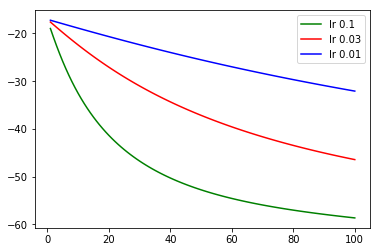

In [25]:
x = [i for i in range(1, len(costAccumulated1)+1)]
plt.plot(x, costAccumulated1, color='green', label="lr 0.1")
plt.plot(x, costAccumulated2, color='red', label="lr 0.03")
plt.plot(x, costAccumulated3, color='blue', label="lr 0.01")
plt.legend()

As we can see, the learning rate does affect the cost function. In this example, the greater the learing rate, the faster the deacrease of the cost function. This means that the model has the capacity to learn faster and a smaller learning rate slows the training. It's not always the same and in other situation, having the learing rate set to big could make the gradient explode and consequently the model would never converge, but this is another topic.
![Exploding Gradients](https://qph.fs.quoracdn.net/main-qimg-ed4a3867ca90b95b33b95f1b89d8335c-c)

Reference:
1. [Deep Learning Book by Ian Goodfellow and Yoshua Bengio and Aaron Courville](https://www.deeplearningbook.org/)
2. [Coursera - Machine Learning](https://www.coursera.org/learn/machine-learning)
3. https://en.wikipedia.org/wiki/Multiclass_classification
4. https://www.codeproject.com/Articles/821347/MultiClass-Logistic-Classifier-in-Python
5. https://www.pugetsystems.com/labs/hpc/Machine-Learning-and-Data-Science-Multinomial-Multiclass-Logistic-Regression-1007/
6. https://houxianxu.github.io/2015/04/23/logistic-softmax-regression/
